# Coursera IBM Data Science Capstone Project - Week 3 

## Segmenting and Clustering Neighborhoods in Toronto 

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information.

In [1]:
!pip install geopy
!pip install folium==0.5.0
!pip install bs4

     |████████████████████████████████| 112kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 122kB 4.7MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium
from folium import plugins

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans 

print("All libraries imported")

All libraries imported


### Part 1 - Webscraping, Data Wrangling, and Cleaning

For the Toronto neighborhood data, a Wikipedia page exists that provides information about the postal code and borough of each neighborhood in Toronoto: https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969

- Scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe
- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [3]:
wiki_url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969'

wiki_data = requests.get(wiki_url).text

In [4]:
# Create soup object of data from Wikipedia

wiki_soup = BeautifulSoup(wiki_data, 'html5lib')

In [5]:
# Scrape the table in the Wikipedia page for the PostalCode, Borough, and Neighborhood

# Setup lists for postal_code, borough, and neighborhood
post_list = []
boro_list = []
neighb_list = []

tab_bodies = wiki_soup.find_all('tbody')

tab_data = tab_bodies[0]

for i, row in enumerate(tab_data.find_all('tr')):
    if i == 0:
        headers = row.find_all('th')
        postal_header = headers[0].getText().strip()
        borough_header = headers[1].getText().strip()
        neighborhood_header = headers[2].getText().strip()
    else:
        cols = row.find_all('td')
        postal_code = cols[0].getText()
        borough = cols[1].getText()
        neighborhood = cols[2].getText()
        
        post_list.append(postal_code.strip())
        boro_list.append(borough.strip())
        neighb_list.append(neighborhood.strip())


In [6]:
# Create pandas dataframe containing postal_code, borough, neighborhood information

toronto_data = {postal_header : post_list,
               borough_header : boro_list,
               neighborhood_header : neighb_list}

tor_df = pd.DataFrame(toronto_data)
tor_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We are going to ignore the postal codes that have 'Not Assigned' boroughs and neighborhoods because there is no information that will be lost from removing these rows and no information gained from keeping them

In [7]:
# Replacing 'Not assigned' to NaN, so we could drop those rows later
tor_df['Borough'].replace('Not assigned', np.nan, inplace = True)
tor_df.shape

(180, 3)

In [8]:
# Dropping cells with unassigned boroughs (NaN)

tor_df.dropna(subset = ['Borough'], axis = 0, inplace = True)

In [9]:
# Sorting the dataframe by postal code to match with the geospatial coordinates

tor_df.sort_values(by=['Postal Code'], inplace = True)
tor_df.reset_index(drop = True, inplace=True)
tor_df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
tor_df.shape

(103, 3)

### Part 2 - Adding Coordinate Data
A csv file containing the coordinate data for each postal code was given. The longitude, latitude data for each postal code was read and added to a dataframe

In [12]:
# read coordinate data into a pandas dataframe
filename = 'https://cocl.us/Geospatial_data'
coord_data = pd.read_csv(filename)
coord_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# merge the toronto dataframe with the coordinates based on Postal Code
toronto_df = pd.merge(tor_df, coord_data, on = 'Postal Code')
toronto_df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace = True)


print(toronto_df.shape)
toronto_df.head()

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


A map using Folium is created based on the latitude, longitude of each neighborhood. 

As you zoom in on the map different neighborhoods can be seen. Clicking on each dot will show which neighborhood the dot represents

In [14]:
# Latitude and Longitude coordinates for Toronto

TOR_LAT = 43.6532
TOR_LONG = - 79.3832

In [15]:
# Plot map of neighborhoods in toronto

toronto_map = folium.Map(location = [TOR_LAT, TOR_LONG], zoom_start = 10)

mark_cluster = plugins.MarkerCluster().add_to(toronto_map)

for lat, long, label in zip(toronto_df.Latitude, toronto_df.Longitude, toronto_df.Neighborhood):
    folium.features.CircleMarker([lat, long],
                                radius = 5,
                                color = 'blue',
                                fill = True,
                                fill_color = 'blue',
                                fill_opacity = 0.5,
                                popup = folium.Popup(label, parse_html = True)).add_to(mark_cluster)

toronto_map

In [17]:
# Count of all the different boroughs in Toronto
toronto_df['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 4
Toronto/York         1
Mississauga          1
Name: Borough, dtype: int64

### Part 3 - Finding Top Venues in each Neighborhood using the Foursquare API

Next, we are going to find the top 100 venues within 500 meters each neighborhood of the Toronto Boroughs. We will then use this information to compare and cluster neighborhoods based on their similarity

In the Foursquare API, a venue is any public place listed on the website. 

A call to the API requires credentials, which can be created on the website, as well as location information. More information about the API can be read on the website: https://developer.foursquare.com/docs/api-reference/venues/search/

The API call returns id, name, location, and category information for the venues. The category represents what type of place the venue is (restaurant, museum, park, etc.)

In [ ]:
# create dataframe for venues in each neighborhood
city_venues_df = pd.DataFrame(columns=['venue_name', 'category', 'venue_lat', 'venue_long', 'neighborhood', 'neighb_lat', 'neighb_long'])
city_venues_df

In [18]:
# make a tuple of latitude and longitude coordinates for each neighborhood in toronto_df
neighb_coord = []

for neighb, n_lat, n_long in zip(toronto_df.Neighborhood, toronto_df.Latitude, toronto_df.Longitude):
    neighb_coord.append((neighb, n_lat, n_long))
    
neighb_coord[0:4]

[('Malvern, Rouge', 43.806686299999996, -79.19435340000001),
 ('Rouge Hill, Port Union, Highland Creek', 43.7845351, -79.16049709999999),
 ('Guildwood, Morningside, West Hill', 43.7635726, -79.1887115),
 ('Woburn', 43.7709921, -79.21691740000001)]

#### Making Calls to the Foursquare API

Calls to the Foursquare API require credentials. I initially used my credentials to make calls to the API. I then stored the data into a csv file to use later and deleted the credentials for privacy reasons.

In [39]:
# Credentials were removed -- requests to API won't work without it
CLIENT_ID = 'ZOGYZYX4FJBVRUACLNGHYT1VAMOPMM4UEEMNN3DMXNX1CUEF' # your Foursquare ID
CLIENT_SECRET = 'GO4VKJZVNWY3ZHEL4AVRNWMPV4AQMRKV3WIRGVMPQOULXLAU'
#ACCESS_TOKEN = ''
ACCESS_TOKEN = '1KWTD441GWPQW30Q0ZOP5NSLION5M2SAJFRHYVCKF4K3UCLH'
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 500


In [40]:
# loop through each place neighborhood and make a call to the API for the top 100 venues within 500 meters of the neighborhood 

venues_list = []

for index, location in enumerate(neighb_coord):
    neighb_lat = neighb_coord[index][1]
    neighb_long = neighb_coord[index][2]

    try:
        url = 'https://api.foursquare.com/v2/venues/explore?oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(ACCESS_TOKEN,
                                                                                                                VERSION,
                                                                                                                neighb_lat,
                                                                                                                neighb_long,
                                                                                                                RADIUS,
                                                                                                                LIMIT)
        venues_data = requests.get(url).json()
        venues = venues_data['response']['groups'][0]['items']
        print(neighb_coord[index][0])
    
        for venue in venues:
            venues_list.append((venue['venue']['name'],
                              venue['venue']['categories'][0]['name'],
                              venue['venue']['location']['lat'],
                              venue['venue']['location']['lng'],
                               neighb_coord[index][0],
                               neighb_coord[index][1],
                               neighb_coord[index][2]))
            
    except:
        print("Current neighborhood", neighb_coord[index][0],neighb_lat, neighb_long)

print("\n--All done--")

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [41]:
# create dataframe for venues in each neighborhood
city_venues_df = pd.DataFrame(venues_list, columns=['venue_name', 'category', 'venue_lat', 'venue_long', 'neighborhood', 'neighb_lat', 'neighb_long'])
city_venues_df

print(city_venues_df.shape)
city_venues_df.head()

(3081, 7)


,venue_name,category,venue_lat,venue_long,neighborhood,neighb_lat,neighb_long
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056,"Malvern, Rouge",43.806686,-79.194353
1,NT Home Service Inc.,Home Service,43.806411,-79.197736,"Malvern, Rouge",43.806686,-79.194353
2,RIGHT WAY TO GOLF,Golf Course,43.785177,-79.161108,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
4,Great Shine Window Cleaning,Home Service,43.783145,-79.157431,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497


The data from the API is saved to a csv file and read in to use in situations where the API is not available

In [42]:
# save to csv to use later 
city_venues_df.to_csv('all_venue_data.csv', index=False)

In [43]:
# read all_venue_data.csv
city_venues_df = pd.read_csv('all_venue_data.csv')
city_venues_df.head()

,venue_name,category,venue_lat,venue_long,neighborhood,neighb_lat,neighb_long
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056,"Malvern, Rouge",43.806686,-79.194353
1,NT Home Service Inc.,Home Service,43.806411,-79.197736,"Malvern, Rouge",43.806686,-79.194353
2,RIGHT WAY TO GOLF,Golf Course,43.785177,-79.161108,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
3,Chris Effects Painting,Construction & Landscaping,43.784343,-79.163742,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
4,Great Shine Window Cleaning,Home Service,43.783145,-79.157431,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497


In [44]:
"There are {} unique categories".format(len(city_venues_df['category'].unique()))

'There are 316 unique categories'

Create dummy variables for each category. This will allow us to take the mean of each category so we can determine the most frequent category in each neighborhoood

In [45]:
# One-hot-encoding for each venue category 
city_dummies = pd.get_dummies(city_venues_df[['category']], prefix='', prefix_sep='')

city_dummies.insert(0, "Neighb_Name", city_venues_df['neighborhood'])

city_dummies.shape


(3081, 317)

In [46]:
# The dataframe will be grouped by neighborhood and mean of each category will be taken

neighb_grouped = city_dummies.groupby("Neighb_Name").mean().reset_index()

print(neighb_grouped.shape)
neighb_grouped.head()

(98, 317)


,Neighb_Name,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0


We can sort each neighborhood to view the 5 most common types of venues 

In [47]:
num_top_venues = 5

for hood in neighb_grouped['Neighb_Name']:
    print("**"+hood+"**")
    temp = neighb_grouped[neighb_grouped['Neighb_Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

**Agincourt**
            venue  freq
0  Breakfast Spot  0.14
1  Hardware Store  0.14
2  Clothing Store  0.14
3          Lounge  0.14
4    Skating Rink  0.14


**Alderwood, Long Branch**
                venue  freq
0         Pizza Place  0.18
1            Pharmacy  0.09
2                Pool  0.09
3      Sandwich Place  0.09
4  Athletics & Sports  0.09


**Bathurst Manor, Wilson Heights, Downsview North**
               venue  freq
0                Spa  0.06
1     Ice Cream Shop  0.06
2           Pharmacy  0.06
3  Mobile Phone Shop  0.06
4               Bank  0.06


**Bayview Village**
                 venue  freq
0   Chinese Restaurant  0.17
1                  Gym  0.17
2                 Bank  0.17
3                  Spa  0.17
4  Japanese Restaurant  0.17


**Bedford Park, Lawrence Manor East**
                venue  freq
0                 Spa  0.08
1  Italian Restaurant  0.06
2         Pizza Place  0.06
3          Hobby Shop  0.04
4      Massage Studio  0.04


**Berczy Park**
       

Create new dataframe of the top venues for each neighborhood

In [48]:
# number of venues to rank
top_x = 10

# create empty list for dataframe column names
column_names = []

for i in np.arange(0, top_x):
    column_names.append("Venue Rank {}".format(i+1))

# create a new dataframe that contains the most frequently appearing venues in each neighborhood
ranked_venues = pd.DataFrame(columns = column_names)
ranked_venues.insert(0, 'Neighborhood', neighb_grouped['Neighb_Name'])

ranked_venues.head()

,Neighborhood,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Agincourt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Alderwood, Long Branch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Bathurst Manor, Wilson Heights, Downsview North",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bayview Village,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bedford Park, Lawrence Manor East",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
for ind in neighb_grouped.index:
    ranked_venues.iloc[ind, 1:] = most_common_venues(neighb_grouped.iloc[ind, :], top_x)
    
ranked_venues.head()

,Neighborhood,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Agincourt,Breakfast Spot,Hardware Store,Skating Rink,Fireworks Store,Latin American Restaurant,Lounge,Clothing Store,Empanada Restaurant,Donut Shop,Drugstore
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Sandwich Place,Athletics & Sports,Pub,Dance Studio,Pool,Coffee Shop,Gym,Skating Rink
2,"Bathurst Manor, Wilson Heights, Downsview North",Spa,Ice Cream Shop,Mobile Phone Shop,Bank,Coffee Shop,Pharmacy,Chinese Restaurant,Diner,Supermarket,Sushi Restaurant
3,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Spa,Café,Gym,Yoga Studio,Empanada Restaurant,Drugstore,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Spa,Italian Restaurant,Pizza Place,Massage Studio,Juice Bar,Boutique,Coffee Shop,Sandwich Place,Business Service,Hobby Shop


The *ranked_venues* dataframe shows which type of venues most frequently appear in each neighborhood

### Part 4 - Clustering Neighborhoods

Use the k-means algorithm to cluster each neighborhood. This will group neighborhoods into similar clusters based on similarity of venues. 

ValueError: x and y must have same first dimension, but have shapes (19,) and (9,)

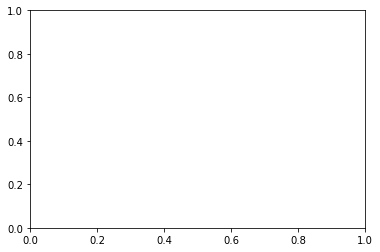

In [54]:
# Determine the optimal number of clusters to use in model using 'elbow method'

# Drop column with neighborhood names so clustering could be done just based on venues
neighb_clusters = neighb_grouped.drop('Neighb_Name', axis=1)

X = neighb_clusters

sse = []
for i in range(1, 20):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    sse.append(km.inertia_)
    
# plot the distortion for number of clusters   
plt.plot(range(1, 20), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.tight_layout()


plt.show()

In [55]:

neighb_clusters = neighb_grouped.drop('Neighb_Name', axis=1)

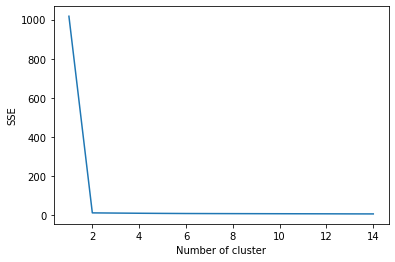

In [58]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k).fit(neighb_clusters)
    neighb_clusters["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [59]:
X=neighb_clusters

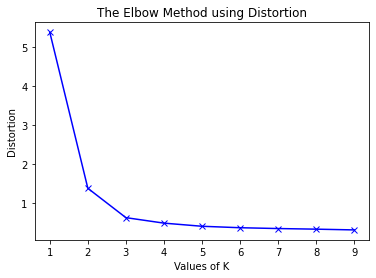

In [63]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

The optimal number of clusters (k) seems to be at 7. There doesn't seem to be a dramatic shift in distortion to definitively say 7 is the optimal number, so other methods to determine the optimal number of clusters can be done to compare

In [52]:
k_clusters = 7

neighb_clusters = neighb_grouped.drop('Neighb_Name', axis=1)

k_means = KMeans(n_clusters = k_clusters).fit(neighb_clusters)

k_labels = k_means.labels_

k_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 0, 1, 6, 0, 6, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       6, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4,
       0, 6, 0, 6, 0, 0, 0, 0, 3, 6], dtype=int32)

Add the cluster labels to the *ranked_venues* dataframe. Now we know which cluster each neighborhood belongs to

In [53]:
if 'Cluster Labels' in ranked_venues.columns:
    ranked_venues.drop(['Cluster Labels'], axis = 1, inplace = True)

ranked_venues.insert(0, 'Cluster Labels', k_labels)
ranked_venues.head()

,Cluster Labels,Neighborhood,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,0,Agincourt,Breakfast Spot,Hardware Store,Skating Rink,Fireworks Store,Latin American Restaurant,Lounge,Clothing Store,Empanada Restaurant,Donut Shop,Drugstore
1,0,"Alderwood, Long Branch",Pizza Place,Pharmacy,Sandwich Place,Athletics & Sports,Pub,Dance Studio,Pool,Coffee Shop,Gym,Skating Rink
2,0,"Bathurst Manor, Wilson Heights, Downsview North",Spa,Ice Cream Shop,Mobile Phone Shop,Bank,Coffee Shop,Pharmacy,Chinese Restaurant,Diner,Supermarket,Sushi Restaurant
3,0,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Spa,Café,Gym,Yoga Studio,Empanada Restaurant,Drugstore,Dumpling Restaurant
4,0,"Bedford Park, Lawrence Manor East",Spa,Italian Restaurant,Pizza Place,Massage Studio,Juice Bar,Boutique,Coffee Shop,Sandwich Place,Business Service,Hobby Shop


Create a new dataframe merging the top venues dataframe with the toronto dataframe. This way we can use the geographic coordinates to map each neighborhood into its cluster

In [ ]:
toronto_merged = toronto_df

toronto_merged = pd.merge(left = toronto_merged, right = ranked_venues, on ='Neighborhood')

print(toronto_merged.shape)
toronto_merged.head()

Map the clusters on a map to show which neighborhoods belong to similar clusters

In [ ]:
cluster_map = folium.Map(location =[TOR_LAT, TOR_LONG], zoom_start = 10)

x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighb, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(neighb) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

An initial look at the map seems to show a distinction between the center of the city and its surrounding neighborhoods. We will look a little closer to understand a little more about each cluster

### Examine the 5 clusters

Creating functions to examine most common boroughs and venues in each cluster

In [ ]:
def top_boroughs(cluster):
    """
    returns the count of the  top 'x' boroughs in a certain cluster
    """
    top_boroughs = cluster['Borough'].value_counts().to_frame().reset_index()
    top_boroughs.rename(columns={'index':'borough', 'Borough':'count'}, inplace = True)

    
    return top_boroughs

In [ ]:
def plot_top_boroughs(cluster_name, cluster_num):
    '''
    create bar graph of borough count in each cluster
    '''
    top_boroughs = cluster_name['Borough'].value_counts().to_frame().reset_index()
    top_boroughs.rename(columns={'index':'borough', 'Borough':'count'}, inplace = True)
    
    sns.barplot(x = 'count', y = 'borough', data = top_boroughs)
    
    title = "Most Common Boroughs in Cluster {}".format(cluster_num)
    
    plt.title(label = title, size = 16)
    plt.xlabel("Count", size = 14)
    plt.ylabel("Borough", size = 14)

    for index, value in enumerate(top_boroughs['count']):
        label = value
        plt.annotate(label, xy = (value+0.01, index+0.1))

    plt.show()

In [ ]:
# creating function for counting the top types of venues that appear in each cluster

def top_venue_types(cluster, num_of_venues):
    """
    returns the count of the  top 'x' types of venues in a certain cluster
    """
    cluster_columns = [col for col in cluster.columns if col.startswith('Venue Rank')]
    cluster_top = cluster[cluster_columns].stack().value_counts().to_frame().reset_index()
    cluster_top.rename(columns={'index':'venue_type', 0:'count'}, inplace = True)
    cluster_topx = cluster_top.head(num_of_venues)
    
    return cluster_topx

In [ ]:
def plot_top_venues(cluster_top_venues, cluster_num):
    '''
    Create bar graph for most common venues in a cluster
    '''
    fig = plt.figure(figsize = (10,5))

    splot = sns.barplot(x = 'count', y = 'venue_type', data = cluster_top_venues, palette = 'colorblind')

    title = "Most Common Venues in Cluster {}".format(cluster_num)
    
    plt.title(label = title, size = 16)
    plt.xlabel("Count", size = 14)
    plt.ylabel("Venue Type", size = 14)

    for index, value in enumerate(cluster_top_venues['count']):
        label = value
        plt.annotate(label, xy = (value+0.01, index+0.1))

    plt.show()

**Cluster 0**

In [ ]:
clust0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust0.shape)
clust0.head()

In [ ]:
c0_boroughs = top_boroughs(clust0)
c0_boroughs

In [ ]:
plot_top_boroughs(clust0, 0)

In [ ]:
clust0_top10 = top_venue_types(clust0, 10)
clust0_top10

In [ ]:
plot_top_venues(clust0_top10, 0)

**Cluster 1**

In [ ]:
clust1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust1.shape)
clust1.head()

In [ ]:
top_boroughs(clust1)

In [ ]:
plot_top_boroughs(clust1, 1)

In [ ]:
clust1_top10 = top_venue_types(clust1, 10)
clust1_top10

In [ ]:
plot_top_venues(clust1_top10, 1)

**Cluster 2**

In [ ]:
clust2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust2.shape)
clust2.head()

In [ ]:
clust2_boroughs = top_boroughs(clust2)
clust2_boroughs

In [ ]:
plot_top_boroughs(clust2, 2)

In [ ]:
clust2_top10 = top_venue_types(clust2, 10)
clust2_top10

In [ ]:
plot_top_venues(clust2_top10, 2)

**Cluster 3**

In [ ]:
clust3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust3.shape)
clust3

In [ ]:
c3_boroughs = top_boroughs(clust3)
c3_boroughs

In [ ]:
plot_top_boroughs(clust3, 3)

In [ ]:
clust3_top10 = top_venue_types(clust3, 10)
clust3_top10

In [ ]:
plot_top_venues(clust3_top10, 3)

**Cluster 4**

In [ ]:
clust4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust4.shape)
clust4

In [ ]:
c4_boroughs = top_boroughs(clust4)
c4_boroughs

In [ ]:
plot_top_boroughs(clust4, 4)

In [ ]:
clust4_top10 = top_venue_types(clust4, 10)
clust4_top10

In [ ]:
plot_top_venues(clust4_top10, 4)

**Cluster 5**

In [ ]:
clust5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust5.shape)
clust5.head()

In [ ]:
c5_boroughs = top_boroughs(clust5)
c5_boroughs

In [ ]:
plot_top_boroughs(clust5, 5)

In [ ]:
clust5_top10 = top_venue_types(clust5, 10)
clust5_top10

In [ ]:
plot_top_venues(clust5_top10, 5)

**Cluster 6**

In [ ]:
clust6 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
print(clust6.shape)
clust6.head()

In [ ]:
c6_boroughs = top_boroughs(clust6)
c6_boroughs

In [ ]:
plot_top_boroughs(clust6, 6)

In [ ]:
clust6_top10 = top_venue_types(clust6, 10)
clust6_top10

In [ ]:
plot_top_venues(clust6_top10, 6)

### References:
- Beautiful Soup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- Folium: https://python-visualization.github.io/folium/
- Foursquare Places API: https://developer.foursquare.com/docs/api-reference/venues/search/
- Pandas: https://pandas.pydata.org/docs/user_guide/index.html#user-guide